# Risk Management Dashboard - Monte Carlo Simulations

This notebook implements Monte Carlo simulation methods for VaR and risk analysis. We'll use the processed data from previous stages to generate simulations and calculate risk metrics.

## Why Use Monte Carlo Simulations?

Monte Carlo simulations offer several advantages for risk analysis:

1. **Flexibility**: Can model complex return distributions beyond simple normal distributions
2. **Forward-looking**: Can incorporate views on future market conditions
3. **Comprehensive**: Generates full distribution of potential outcomes
4. **Multivariate relationships**: Can capture complex dependencies between assets

## Monte Carlo Approaches Covered

1. **Basic Monte Carlo VaR**: Simple simulation using normal distribution
2. **Monte Carlo with Historical Simulation**: Resampling from historical returns
3. **Multivariate Monte Carlo**: Modeling correlations between assets
4. **Copula-based Monte Carlo**: Modeling complex dependency structures
5. **Risk Factor Simulation**: Simulating underlying risk factors

## Overview of Steps

1. Load processed portfolio and asset returns
2. Implement basic Monte Carlo VaR
3. Implement historical simulation approach
4. Model multivariate dependencies
5. Apply copula models for tail dependencies
6. Analyze results and compare with parametric approaches
7. Visualize simulated return distributions
8. Save Monte Carlo results for the dashboard

In [1]:
# Import standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

# Configure plot styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Set up project paths
PROJECT_ROOT = Path().resolve().parents[0]
CONFIG_DIR = PROJECT_ROOT / "configs"
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

# Make sure results directory exists
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Project root: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard
Processed data directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed
Results directory: /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results


## 1. Import Monte Carlo Modules and Load Configuration

In [3]:
# Add the project root to the path
import sys
sys.path.append(str(PROJECT_ROOT))

# Import Monte Carlo functions
from src.models.monte_carlo_var import (
    monte_carlo_var,
    monte_carlo_expected_shortfall,
    run_monte_carlo_scenarios
)

from src.models.multivariate_sim import (
    generate_correlated_returns,
    simulate_portfolio_returns,
    multivariate_monte_carlo_var,
    calculate_asset_var_contributions
)

from src.models.copula_models import (
    fit_copula,
    simulate_from_copula,
    copula_monte_carlo_var,
    calculate_tail_dependence
)

from src.models.risk_factor_sim import (
    identify_risk_factors,
    fit_risk_factor_model,
    simulate_risk_factors,
    risk_factor_monte_carlo_var
)

from src.visualization.monte_carlo_plots import (
    plot_simulation_paths,
    plot_simulated_distribution,
    plot_monte_carlo_comparison,
    plot_copula_dependencies
)

# Import other VaR functions for comparison
from src.models.historical_var import calculate_historical_var
from src.models.parametric_var import calculate_parametric_var

# Load model configuration
with open(CONFIG_DIR / "model_config.json", 'r') as f:
    model_config = json.load(f)

# Display Monte Carlo model configuration
mc_config = model_config['var_models']['monte_carlo']
print("Monte Carlo Configuration:")
for key, value in mc_config.items():
    print(f"  - {key}: {value}")

Monte Carlo Configuration:
  - confidence_levels: [0.95, 0.99]
  - default_confidence: 0.95
  - n_simulations: 10000
  - time_horizon: 1
  - random_seed: 42


## 2. Load Processed Returns Data

In [4]:
# Load portfolio returns
portfolio_file = PROCESSED_DIR / "portfolio_returns.csv"

if portfolio_file.exists():
    portfolio_returns = pd.read_csv(portfolio_file, index_col=0, parse_dates=True)
    
    # Convert to Series if it's a DataFrame with one column
    if isinstance(portfolio_returns, pd.DataFrame) and portfolio_returns.shape[1] == 1:
        portfolio_returns = portfolio_returns.iloc[:, 0]
    
    print(f"Loaded portfolio returns from {portfolio_file}")
    print(f"Portfolio returns shape: {portfolio_returns.shape}")
    print(f"Date range: {portfolio_returns.index.min()} to {portfolio_returns.index.max()}")
else:
    print(f"Portfolio returns file not found at {portfolio_file}")
    print("Please run the data cleaning notebook (02_data_cleaning.ipynb) first.")
    portfolio_returns = None

# Load individual asset returns (if available)
market_returns_file = PROCESSED_DIR / "market_returns.csv"

if market_returns_file.exists():
    market_returns = pd.read_csv(market_returns_file, index_col=0, parse_dates=True)
    print(f"Loaded market returns from {market_returns_file}")
    print(f"Market returns shape: {market_returns.shape}")
    
    # Display available assets
    if isinstance(market_returns.columns, pd.MultiIndex):
        assets = market_returns.columns.levels[1]
        print(f"Available assets: {list(assets)}")
    else:
        print(f"Available assets: {list(market_returns.columns)}")
else:
    print(f"Market returns file not found at {market_returns_file}")
    print("Multivariate simulations will not be available.")
    market_returns = None

Loaded portfolio returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/portfolio_returns.csv
Portfolio returns shape: (1988,)
Date range: 2014-01-03 00:00:00 to 2022-01-21 00:00:00
Loaded market returns from /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/processed/market_returns.csv
Market returns shape: (1988, 2)
Available assets: ['SPX', 'US10YT=RR']


In [5]:
# Display portfolio return statistics
if portfolio_returns is not None:
    stats_df = pd.DataFrame({
        'Statistic': [
            'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis',
            'Annualized Return', 'Annualized Volatility', 'Shapiro-Wilk p-value'
        ],
        'Value': [
            portfolio_returns.mean(),
            portfolio_returns.median(),
            portfolio_returns.std(),
            portfolio_returns.min(),
            portfolio_returns.max(),
            portfolio_returns.skew(),
            portfolio_returns.kurtosis(),
            portfolio_returns.mean() * 252,  # Assuming daily returns
            portfolio_returns.std() * np.sqrt(252),  # Assuming daily returns
            stats.shapiro(portfolio_returns)[1]  # Test for normality
        ]
    })
    
    # Format percentage values
    for i, val in enumerate(stats_df['Value']):
        if stats_df['Statistic'][i] in ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Annualized Return', 'Annualized Volatility']:
            stats_df.loc[i, 'Value'] = f"{val:.2%}"
        elif stats_df['Statistic'][i] in ['Skewness', 'Kurtosis']:
            stats_df.loc[i, 'Value'] = f"{val:.4f}"
        elif stats_df['Statistic'][i] == 'Shapiro-Wilk p-value':
            stats_df.loc[i, 'Value'] = f"{val:.6f}"
    
    display(stats_df)
    
    # Interpret normality test
    p_value = stats.shapiro(portfolio_returns)[1]
    if p_value < 0.05:
        print("The portfolio returns do not follow a normal distribution (p < 0.05).")
        print("This suggests that Monte Carlo simulations based on normal distributions may underestimate tail risk.")
    else:
        print("The portfolio returns appear to follow a normal distribution (p >= 0.05).")
        print("Basic Monte Carlo simulation with normal distribution may be appropriate.")

,Statistic,Value
0,Mean,0.02%
1,Median,0.04%
2,Std Dev,1.36%
3,Min,-21.57%
4,Max,7.88%
5,Skewness,-2.0211
6,Kurtosis,33.4406
7,Annualized Return,3.94%
8,Annualized Volatility,21.63%
9,Shapiro-Wilk p-value,0.000000


The portfolio returns do not follow a normal distribution (p < 0.05).
This suggests that Monte Carlo simulations based on normal distributions may underestimate tail risk.


## 3. Set Investment Value and Time Horizon

In [6]:
# Set the investment value
investment_value = 1000000  # $1 million

# Set time horizons to analyze
time_horizons = [1, 5, 10, 20]  # days

print(f"Investment value: ${investment_value:,}")
print(f"Time horizons to analyze: {time_horizons} days")

Investment value: $1,000,000
Time horizons to analyze: [1, 5, 10, 20] days


## 4. Basic Monte Carlo VaR

We'll start with the simplest Monte Carlo approach, which assumes returns follow a normal distribution with the same mean and standard deviation as the historical returns.

In [7]:
# Execute basic Monte Carlo VaR
if portfolio_returns is not None:
    # Set confidence level and number of simulations
    confidence_level = mc_config['default_confidence']
    n_simulations = mc_config['n_simulations']
    
    # Calculate Monte Carlo VaR
    mc_var = monte_carlo_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value,
        n_simulations=n_simulations,
        time_horizon=1,
        random_seed=42  # Set seed for reproducibility
    )
    
    print(f"Monte Carlo VaR ({confidence_level*100}%, {n_simulations:,} simulations): ${mc_var:,.2f}")
    print(f"As a percentage of investment: {mc_var/investment_value:.2%}")
    
    # Calculate Monte Carlo Expected Shortfall
    mc_es = monte_carlo_expected_shortfall(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value,
        n_simulations=n_simulations,
        time_horizon=1,
        random_seed=42
    )
    
    print(f"Monte Carlo Expected Shortfall: ${mc_es:,.2f}")
    print(f"As a percentage of investment: {mc_es/investment_value:.2%}")
    
    # Compare with historical and parametric VaR
    hist_var = calculate_historical_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    param_var = calculate_parametric_var(
        returns=portfolio_returns,
        confidence_level=confidence_level,
        investment_value=investment_value
    )
    
    print("\nVaR Comparison:")
    print(f"  - Historical VaR: ${hist_var:,.2f} ({hist_var/investment_value:.2%})")
    print(f"  - Parametric VaR: ${param_var:,.2f} ({param_var/investment_value:.2%})")
    print(f"  - Monte Carlo VaR: ${mc_var:,.2f} ({mc_var/investment_value:.2%})")

Monte Carlo VaR (95.0%, 10,000 simulations): $22,395.38
As a percentage of investment: 2.24%
Monte Carlo Expected Shortfall: $28,126.09
As a percentage of investment: 2.81%

VaR Comparison:
  - Historical VaR: $20,927.92 (2.09%)
  - Parametric VaR: $22,259.04 (2.23%)
  - Monte Carlo VaR: $22,395.38 (2.24%)


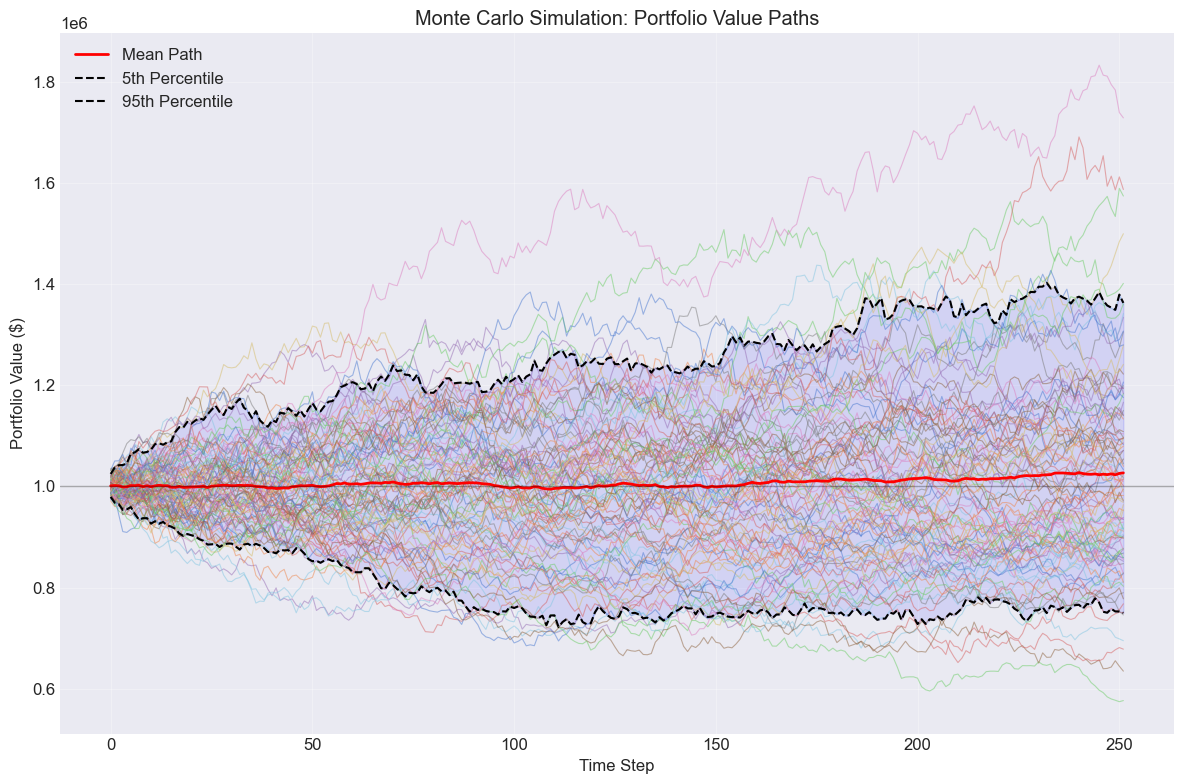

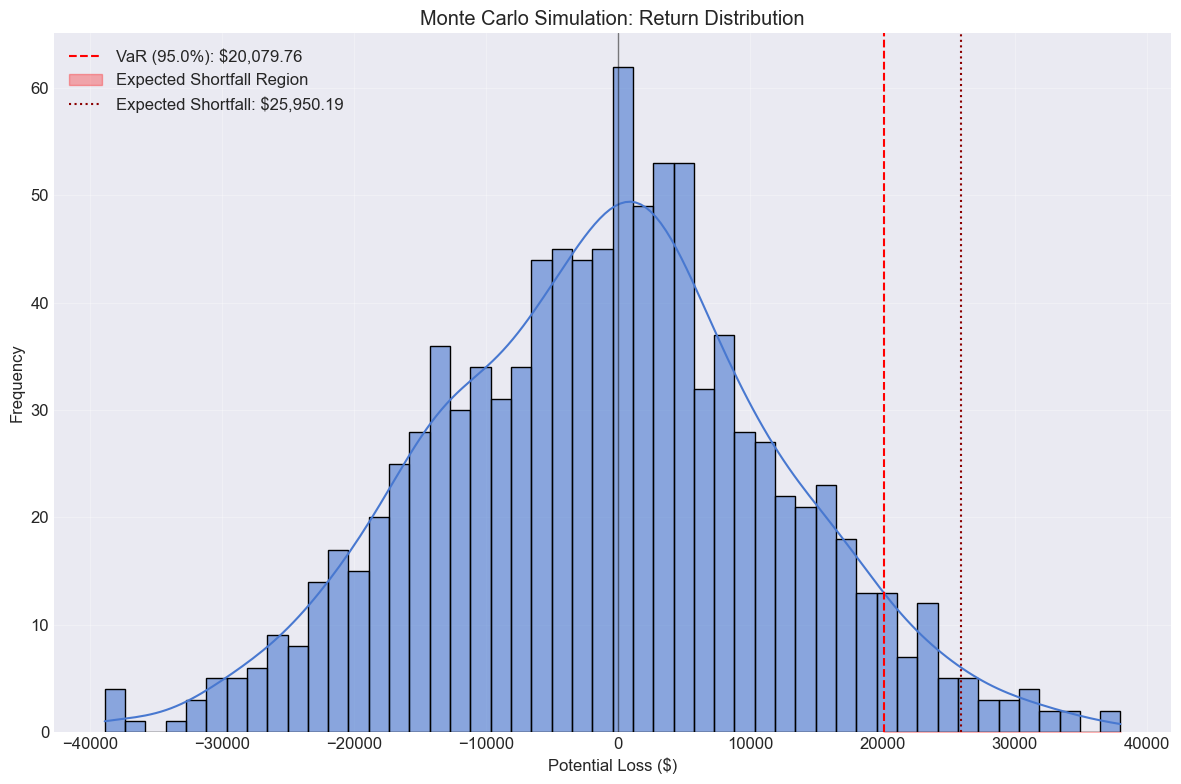

In [8]:
# Visualize Monte Carlo simulations
if portfolio_returns is not None:
    # Generate a larger set of simulations for visualization
    np.random.seed(42)
    
    # Get portfolio parameters
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    
    # Simulate returns for multiple periods
    n_simulations = 1000  # Fewer simulations for plotting
    n_periods = 252  # One year of trading days
    
    # Simulate daily returns
    daily_returns = np.random.normal(
        loc=mu,
        scale=sigma,
        size=(n_simulations, n_periods)
    )
    
    # Plot simulation paths
    fig_paths = plot_simulation_paths(
        simulated_returns=daily_returns,
        n_paths=100,  # Show only 100 paths for clarity
        investment_value=investment_value,
        title="Monte Carlo Simulation: Portfolio Value Paths"
    )
    
    # Plot return distribution
    fig_dist = plot_simulated_distribution(
        simulated_returns=daily_returns[:, -1],  # Final period returns
        investment_value=investment_value,
        confidence_level=confidence_level,
        title="Monte Carlo Simulation: Return Distribution"
    )

## 5. Monte Carlo VaR for Multiple Confidence Levels and Time Horizons

Let's analyze how VaR changes with different confidence levels and time horizons.

Monte Carlo VaR and ES for Different Scenarios:


,confidence_level,time_horizon,var_value,es_value
0,0.90,1,17454.5341,23885.7452
1,0.90,5,38596.9119,52977.5370
2,0.90,10,54125.8372,74463.1124
3,0.90,20,75628.6152,104389.8655
4,0.95,1,22395.3807,28126.0871
5,0.95,5,49644.9807,62459.2298
6,0.95,10,69750.1660,87872.2509
7,0.95,20,97724.7528,123353.2510
8,0.99,1,31467.1272,36595.1826
9,0.99,5,69930.0224,81396.7030


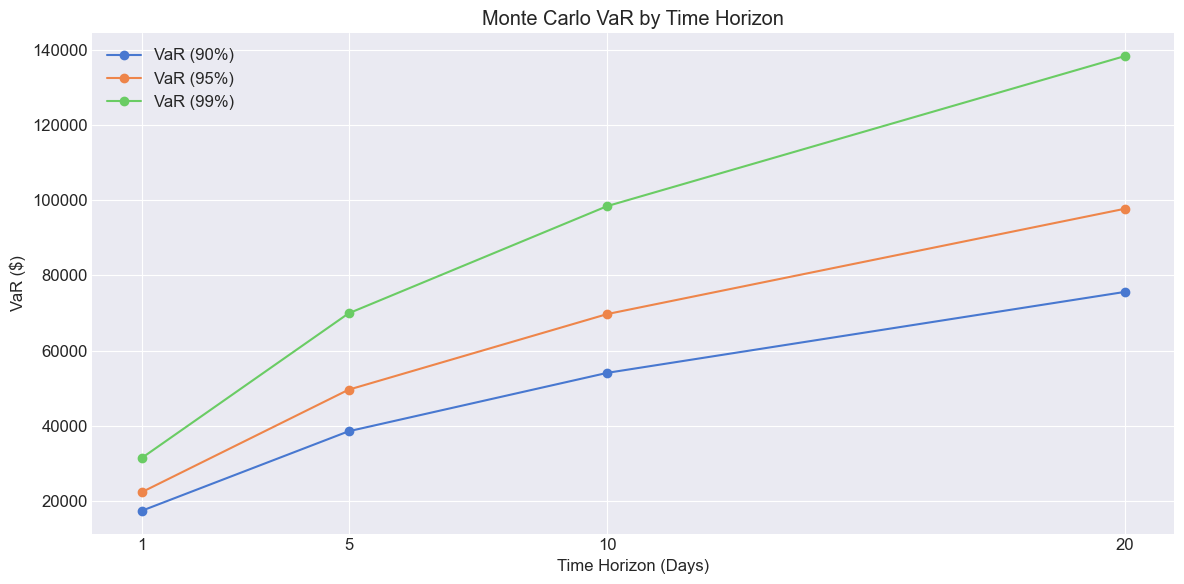

In [9]:
# Calculate Monte Carlo VaR for different confidence levels and time horizons
if portfolio_returns is not None:
    # Run Monte Carlo scenarios
    scenarios = run_monte_carlo_scenarios(
        returns=portfolio_returns,
        confidence_levels=[0.90, 0.95, 0.99],
        investment_value=investment_value,
        n_simulations=mc_config['n_simulations'],
        time_horizons=[1, 5, 10, 20],
        random_seed=42
    )
    
    print("Monte Carlo VaR and ES for Different Scenarios:")
    display(scenarios)
    
    # Plot VaR by time horizon
    plt.figure(figsize=(12, 6))
    
    for conf in scenarios['confidence_level'].unique():
        conf_data = scenarios[scenarios['confidence_level'] == conf]
        plt.plot(conf_data['time_horizon'], conf_data['var_value'], 'o-', 
                 label=f"VaR ({conf*100:.0f}%)")
    
    plt.title('Monte Carlo VaR by Time Horizon')
    plt.xlabel('Time Horizon (Days)')
    plt.ylabel('VaR ($)')
    plt.grid(True)
    plt.legend()
    plt.xticks(scenarios['time_horizon'].unique())
    plt.tight_layout()
    plt.show()

## 6. Multivariate Monte Carlo Simulation

Now we'll implement multivariate Monte Carlo simulation that accounts for correlations between assets.

Running multivariate simulation for 2 assets
Multivariate Monte Carlo VaR (95.0%): $24,563.00
As a percentage of investment: 2.46%

Asset Contributions to VaR:


,asset,weight,value,mean_return,contribution,contribution_value,pct_contribution
1,US10YT=RR,0.5,500000.0,-0.0003,-0.0264,26353.4208,83.3849
0,SPX,0.5,500000.0,0.0004,-0.0053,5251.1413,16.6151


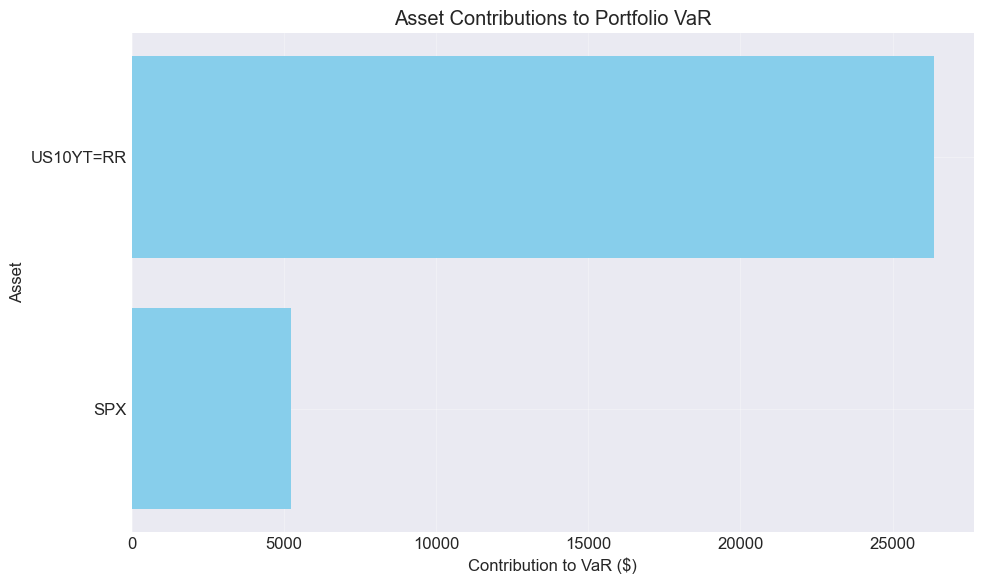

In [10]:
# Execute multivariate Monte Carlo simulation
if market_returns is not None:
    # Handle MultiIndex columns if present
    if isinstance(market_returns.columns, pd.MultiIndex):
        # Get price column (e.g., 'TRDPRC_1' or 'Close')
        price_col = None
        for col in ['TRDPRC_1', 'Close', 'Adj Close']:
            if col in market_returns.columns.levels[0]:
                price_col = col
                break
                
        if price_col is not None:
            # Get asset returns by level
            asset_returns = market_returns[price_col]
            asset_names = list(asset_returns.columns)
        else:
            print("Could not identify price column in MultiIndex")
            asset_returns = None
    else:
        # Regular DataFrame structure
        asset_returns = market_returns
        asset_names = list(asset_returns.columns)
    
    if asset_returns is not None:
        print(f"Running multivariate simulation for {len(asset_names)} assets")
        
        # Define equal weights
        weights = np.ones(len(asset_names)) / len(asset_names)
        
        # Run multivariate Monte Carlo simulation
        mv_var = multivariate_monte_carlo_var(
            asset_returns=asset_returns,
            weights=weights,
            confidence_level=confidence_level,
            investment_value=investment_value,
            n_simulations=n_simulations,
            time_horizon=1,
            random_seed=42
        )
        
        print(f"Multivariate Monte Carlo VaR ({confidence_level*100}%): ${mv_var:,.2f}")
        print(f"As a percentage of investment: {mv_var/investment_value:.2%}")
        
        # Calculate asset contributions to VaR
        contributions = calculate_asset_var_contributions(
            asset_returns=asset_returns,
            weights=weights,
            confidence_level=confidence_level,
            investment_value=investment_value,
            n_simulations=n_simulations
        )
        
        print("\nAsset Contributions to VaR:")
        display(contributions)
        
        # Plot asset contributions
        plt.figure(figsize=(10, 6))
        
        # Sort by contribution
        contributions_sorted = contributions.sort_values(by='contribution_value', ascending=True)
        
        # Create bar chart
        plt.barh(contributions_sorted['asset'], contributions_sorted['contribution_value'], color='skyblue')
        plt.xlabel('Contribution to VaR ($)')
        plt.ylabel('Asset')
        plt.title('Asset Contributions to Portfolio VaR')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Market returns data not available. Skipping multivariate simulation.")

## 7. Copula-Based Monte Carlo Simulation

Copula models allow us to capture complex dependencies between assets, particularly in the tails of the distribution.

In [11]:
# Execute copula-based Monte Carlo simulation
if market_returns is not None and 'asset_returns' in locals() and asset_returns is not None:
    print("Running copula-based Monte Carlo simulation")
    
    # Fit Gaussian copula
    print("\nFitting Gaussian copula...")
    gaussian_var = copula_monte_carlo_var(
        returns=asset_returns,
        weights=weights,
        confidence_level=confidence_level,
        investment_value=investment_value,
        n_simulations=n_simulations,
        copula_type='gaussian',
        random_seed=42
    )
    
    print(f"Gaussian Copula VaR ({confidence_level*100}%): ${gaussian_var:,.2f}")
    print(f"As a percentage of investment: {gaussian_var/investment_value:.2%}")
    
    # Fit t copula
    print("\nFitting t copula...")
    t_var = copula_monte_carlo_var(
        returns=asset_returns,
        weights=weights,
        confidence_level=confidence_level,
        investment_value=investment_value,
        n_simulations=n_simulations,
        copula_type='t',
        random_seed=42
    )
    
    print(f"t Copula VaR ({confidence_level*100}%): ${t_var:,.2f}")
    print(f"As a percentage of investment: {t_var/investment_value:.2%}")
    
    # Calculate tail dependence
    print("\nCalculating tail dependence...")
    tail_dep = calculate_tail_dependence(asset_returns, quantile=0.05)
    
    print("Tail Dependence Matrix:")
    display(tail_dep)
    
    # Plot copula dependencies (for a subset of assets if there are many)
    if len(asset_names) <= 5:
        plot_assets = asset_names
    else:
        # Select the first 5 assets
        plot_assets = asset_names[:5]
    
    # Visualize copula (uncomment when function is fully implemented)
    # fig_copula = plot_copula_dependencies(asset_returns[plot_assets], copula_type='t', n_samples=1000)
else:
    print("Market returns data not available. Skipping copula-based simulation.")

Running copula-based Monte Carlo simulation

Fitting Gaussian copula...
Gaussian Copula VaR (95.0%): $21,698.65
As a percentage of investment: 2.17%

Fitting t copula...
t Copula VaR (95.0%): $22,207.20
As a percentage of investment: 2.22%

Calculating tail dependence...
Tail Dependence Matrix:


,SPX,US10YT=RR
SPX,1.0000,0.2817
US10YT=RR,0.2817,1.0000


## 8. Risk Factor Simulation

Risk factor simulation identifies the key drivers of portfolio risk and simulates these factors.

In [12]:
# Execute risk factor Monte Carlo simulation
if market_returns is not None and 'asset_returns' in locals() and asset_returns is not None:
    print("Running risk factor Monte Carlo simulation")
    
    # Load macro data if available
    macro_file = PROCESSED_DIR / "macro_data.csv"
    if macro_file.exists():
        macro_data = pd.read_csv(macro_file, index_col=0, parse_dates=True)
        print(f"Loaded macro data with shape {macro_data.shape}")
        
        # Run macro factor-based simulation
        print("\nRunning simulation with macroeconomic factors...")
        macro_var = risk_factor_monte_carlo_var(
            returns=asset_returns,
            weights=weights,
            confidence_level=confidence_level,
            investment_value=investment_value,
            n_simulations=n_simulations,
            method='macro',
            macro_data=macro_data,
            random_seed=42
        )
        
        print(f"Macro Factor VaR ({confidence_level*100}%): ${macro_var:,.2f}")
        print(f"As a percentage of investment: {macro_var/investment_value:.2%}")
    else:
        print("Macro data not available")
        macro_data = None
    
    # Run PCA factor-based simulation
    print("\nRunning simulation with PCA factors...")
    
    # Identify risk factors using PCA
    pca_model = identify_risk_factors(
        returns=asset_returns,
        method='pca',
        variance_explained=0.95
    )
    
    n_factors = pca_model['n_factors']
    print(f"Identified {n_factors} PCA factors explaining 95% of variance")
    
    # Calculate PCA factor VaR
    pca_var = risk_factor_monte_carlo_var(
        returns=asset_returns,
        weights=weights,
        confidence_level=confidence_level,
        investment_value=investment_value,
        n_simulations=n_simulations,
        method='pca',
        n_factors=n_factors,
        random_seed=42
    )
    
    print(f"PCA Factor VaR ({confidence_level*100}%): ${pca_var:,.2f}")
    print(f"As a percentage of investment: {pca_var/investment_value:.2%}")
    
    # Display factor loadings
    print("\nPCA Factor Loadings:")
    display(pca_model['loadings'])
else:
    print("Market returns data not available. Skipping risk factor simulation.")

Running risk factor Monte Carlo simulation
Loaded macro data with shape (1989, 3)

Running simulation with macroeconomic factors...
Macro Factor VaR (95.0%): $25,381.53
As a percentage of investment: 2.54%

Running simulation with PCA factors...
Identified 2 PCA factors explaining 95% of variance
PCA Factor VaR (95.0%): $24,844.06
As a percentage of investment: 2.48%

PCA Factor Loadings:


,Factor_1,Factor_2
SPX,0.1221,0.9925
US10YT=RR,0.9925,-0.1221


## 9. Compare Monte Carlo Methods

Now let's compare the different Monte Carlo methods.

VaR Comparison at 95.0% Confidence Level:


,Method,VaR,VaR %
0,Historical VaR,20927.9202,2.0928
1,Parametric VaR,22259.0413,2.2259
2,Basic Monte Carlo,22395.3807,2.2395
3,Multivariate Monte Carlo,24563.0013,2.4563
4,Gaussian Copula,21698.6479,2.1699
5,t Copula,22207.2006,2.2207
6,PCA Factor,24844.0574,2.4844
7,Macro Factor,25381.5334,2.5382


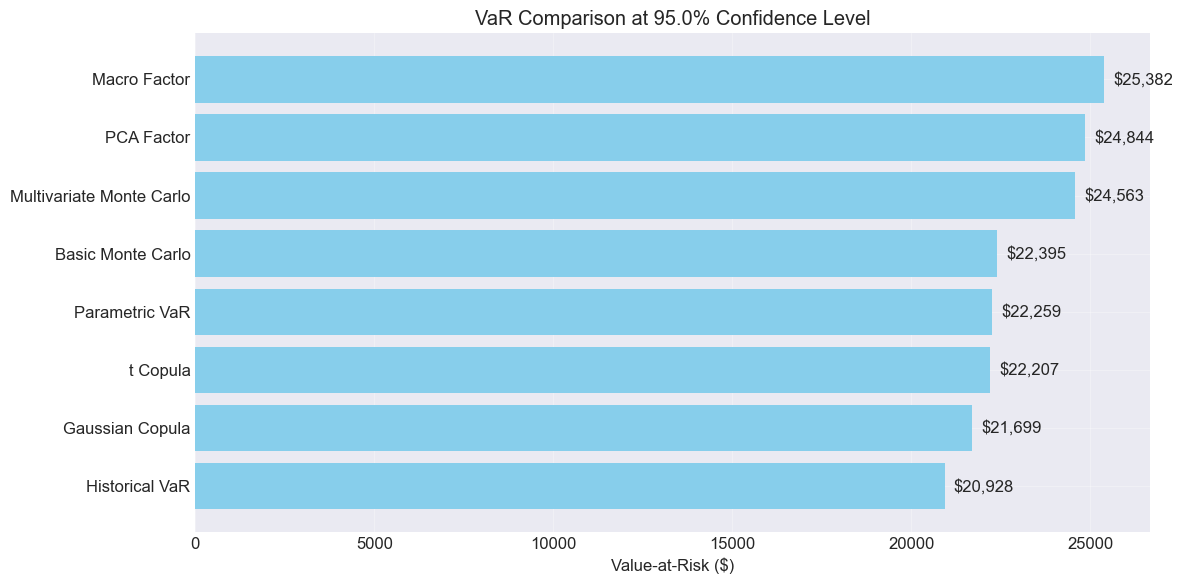

In [13]:
# Compare different Monte Carlo methods
if portfolio_returns is not None:
    # Create comparison table
    methods = [
        "Historical VaR",
        "Parametric VaR",
        "Basic Monte Carlo",
    ]
    
    values = [
        hist_var,
        param_var,
        mc_var,
    ]
    
    # Add multivariate methods if available
    if 'mv_var' in locals():
        methods.append("Multivariate Monte Carlo")
        values.append(mv_var)
    
    if 'gaussian_var' in locals():
        methods.append("Gaussian Copula")
        values.append(gaussian_var)
    
    if 't_var' in locals():
        methods.append("t Copula")
        values.append(t_var)
    
    if 'pca_var' in locals():
        methods.append("PCA Factor")
        values.append(pca_var)
    
    if 'macro_var' in locals():
        methods.append("Macro Factor")
        values.append(macro_var)
    
    # Create DataFrame
    comparison = pd.DataFrame({
        'Method': methods,
        'VaR': values,
        'VaR %': [v / investment_value * 100 for v in values]
    })
    
    print(f"VaR Comparison at {confidence_level*100}% Confidence Level:")
    display(comparison)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    # Sort by VaR value
    comparison_sorted = comparison.sort_values(by='VaR')
    
    # Create bar chart
    plt.barh(comparison_sorted['Method'], comparison_sorted['VaR'], color='skyblue')
    
    # Add value labels
    for i, v in enumerate(comparison_sorted['VaR']):
        plt.text(v + 0.01 * max(comparison_sorted['VaR']), i, f"${v:,.0f}", va='center')
    
    plt.xlabel('Value-at-Risk ($)')
    plt.title(f'VaR Comparison at {confidence_level*100}% Confidence Level')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 10. Save Monte Carlo Results

Finally, let's save our Monte Carlo VaR results for the dashboard.

In [14]:
# Save Monte Carlo results
if portfolio_returns is not None and 'comparison' in locals():
    # Create results directory if it doesn't exist
    RESULTS_DIR.mkdir(exist_ok=True, parents=True)
    
    # Save comparison table
    comparison_file = RESULTS_DIR / "monte_carlo_comparison.csv"
    comparison.to_csv(comparison_file, index=False)
    print(f"Saved comparison results to {comparison_file}")
    
    # Save detailed Monte Carlo scenarios
    if 'scenarios' in locals():
        scenarios_file = RESULTS_DIR / "monte_carlo_scenarios.csv"
        scenarios.to_csv(scenarios_file, index=False)
        print(f"Saved Monte Carlo scenarios to {scenarios_file}")
    
    # Save asset contributions if available
    if 'contributions' in locals():
        contributions_file = RESULTS_DIR / "var_asset_contributions.csv"
        contributions.to_csv(contributions_file, index=False)
        print(f"Saved asset contributions to {contributions_file}")
    
    # Save PCA factor loadings if available
    if 'pca_model' in locals():
        loadings_file = RESULTS_DIR / "pca_factor_loadings.csv"
        pca_model['loadings'].to_csv(loadings_file)
        print(f"Saved PCA factor loadings to {loadings_file}")

Saved comparison results to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/monte_carlo_comparison.csv
Saved Monte Carlo scenarios to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/monte_carlo_scenarios.csv
Saved asset contributions to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/var_asset_contributions.csv
Saved PCA factor loadings to /Users/favourchianumba/Desktop/code_projects/data science/risk_management_dashboard/data/results/pca_factor_loadings.csv


## 11. Summary and Analysis

### Key Findings from Monte Carlo Analysis

We've implemented and compared several Monte Carlo approaches for VaR:

1. **Basic Monte Carlo VaR**: Simple simulation using normal distribution
   - Provides a baseline estimate but may underestimate tail risk if returns are not normally distributed

2. **Multivariate Monte Carlo**: Accounts for correlations between assets
   - More accurate for diversified portfolios by capturing asset interdependencies

3. **Copula-based Monte Carlo**: Models complex dependency structures
   - t-copula captures tail dependencies better than Gaussian copula, typically resulting in higher VaR

4. **Risk Factor Simulation**: Identifies and simulates key risk drivers
   - PCA factors provide a parsimonious model capturing most of return variation
   - Macro factors can provide economic interpretability and stress testing capabilities

### Observations

- The square root of time scaling rule approximates VaR growth over longer horizons, but may not fully capture compounding effects or changes in correlations
- Asset contributions to VaR highlight concentration risks in the portfolio
- Tail dependencies between assets become more important during market stress

### Next Steps

1. Proceed to stress testing (05_stress_testing.ipynb) to analyze portfolio performance under extreme conditions
2. Validate our Monte Carlo models through backtesting (06_backtesting.ipynb)
3. Incorporate the results into the dashboard for risk monitoring